# Instructions

In order to run this Python notebook, click on each cell, then press Shift+Enter. You can do this for all cells that you want to run. This may take some time. The model will execute and visualize the training of the evolution and DQN models.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from IPython.display import HTML
from collections import deque
import importlib
import seaborn as sns #remove
sns.set()
sns.set(style="whitegrid")
import simulation
import controller
from simulation import *
from genetic_utils import *
from dqn_main_bus import DQNMainBus
from main_bus import MainBus
from genetic_main_bus import GeneticMainBus

In [3]:
# Parameters
whole_day = 1440

In [4]:
# Retreives results from a simulation
def get_results(simulation):
    num_del = simulation.controller.num_passengers_delivered
    expenses = simulation.controller.get_total_cost()
    cost_ratio = expenses/num_del
    num_messages = simulation.controller.get_messages_sent()
    awt = (simulation.controller.total_waiting_time ) / \
        (simulation.controller.num_passengers_delivered + simulation.controller.actual_passenger_count)
    return awt, expenses, num_messages, num_del, cost_ratio

# Evolutionary Approach

In [14]:
# initialization of the simulation and the parameters

genetic_simulation = Simulation(GeneticMainBus)
initial_genomes = [[1, 0.5, 0.5, 0.5, 0.5, 0.05], [2, 0.5, 0.5, 0.5, 0.5, 0.08], [3, 0.5, 0.5, 0.5, 0.5, 0.1]]
genome_distro = [0.30, 0.35, 0.35]
np.random.seed(1234)

Initializing Prob Dist


In [15]:
# First day iteration
genetic_simulation.reset(bus_genomes=initial_genomes, genome_distro=genome_distro)
genetic_simulation.execute(iterations=whole_day, animate=False)

 1440 / 1440 

{}

In [16]:
# Initial Results

awt, expenses, num_messages, num_del, cost_ratio = get_results(genetic_simulation)

print('\n\tDelivered: {}'.format(num_del))
print('\tExpenses: {}'.format(expenses))
print('\tExpenses/Pass Del: {}'.format(cost_ratio))
print('\tMessages: {}'.format(num_messages))
print('\tAWT: {}'.format(awt))

bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in genetic_simulation.controller.buses.values() ])
bus_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])
init_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])

best_perf = awt
best_fitness = bus_fitness
best_genomes = bus_genomes

awt_over_time = [awt]
expenses_over_time = [expenses]
messages_over_time = [num_messages]
delivered_over_time = [num_del]
cost_ratio_over_time = [cost_ratio]


	Delivered: 42189
	Expenses: 1100324
	Expenses/Pass Del: 26.080826755789424
	Messages: 26139
	AWT: 100.65737024997198


### Evolutionary algorithm run

In [18]:
n_iterations = 5

# Evolution
for _ in range(n_iterations):
    
    np.random.seed(1234)
    # Evolution step
    (new_genomes, new_distro) = create_new_population(bus_genomes, bus_fitness, 0.7, 0.2, 0.1)
    
    # Evaluation
    genetic_simulation.reset(bus_genomes = new_genomes, genome_distro= new_distro)
    
    genetic_simulation.execute(iterations=whole_day, animate=False)
    
    # Get population stats
    bus_fitness = np.array([bus.cum_reward / MainBus._bus_type_travel_cost[bus.bus_type] for bus in genetic_simulation.controller.buses.values() ])
    bus_genomes = np.array([bus.genome for bus in genetic_simulation.controller.buses.values() ])

    # Display and save results
    awt, expenses, num_messages, num_del, cost_ratio = get_results(genetic_simulation)
    
    awt_over_time.append(awt)
    expenses_over_time.append(expenses)
    messages_over_time.append(num_messages)
    delivered_over_time.append(num_del)
    cost_ratio_over_time.append(cost_ratio)
    
    print('\n\tDelivered: {}'.format(num_del))
    print('\tExpenses: {}'.format(expenses))
    print('\tExpenses/Pass Del: {}'.format(cost_ratio))
    print('\tMessages: {}'.format(num_messages))
    print('\tAWT: {}'.format(awt))
    
    if awt < best_perf:
        best_perf = awt
        best_fitness = bus_fitness
        best_genomes = bus_genomes
        


 1440 / 1440 
	Delivered: 42132
	Expenses: 1099694
	Expenses/Pass Del: 26.10115826450204
	Messages: 27125
	AWT: 104.90436049770206
 1440 / 1440 
	Delivered: 41790
	Expenses: 1139699
	Expenses/Pass Del: 27.272050729839673
	Messages: 26783
	AWT: 102.86059858760228
 1440 / 1440 
	Delivered: 41464
	Expenses: 1267799
	Expenses/Pass Del: 30.575897163804747
	Messages: 27902
	AWT: 88.80728617867952
 1440 / 1440 
	Delivered: 42257
	Expenses: 1088834
	Expenses/Pass Del: 25.766949854461984
	Messages: 28962
	AWT: 82.81031274520794
 1440 / 1440 
	Delivered: 42024
	Expenses: 1122014
	Expenses/Pass Del: 26.699362269179517
	Messages: 29709
	AWT: 85.25609236632664


82.81031274520794


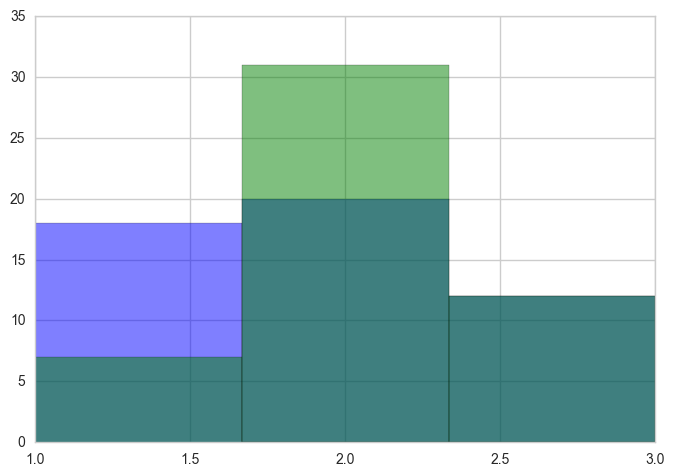

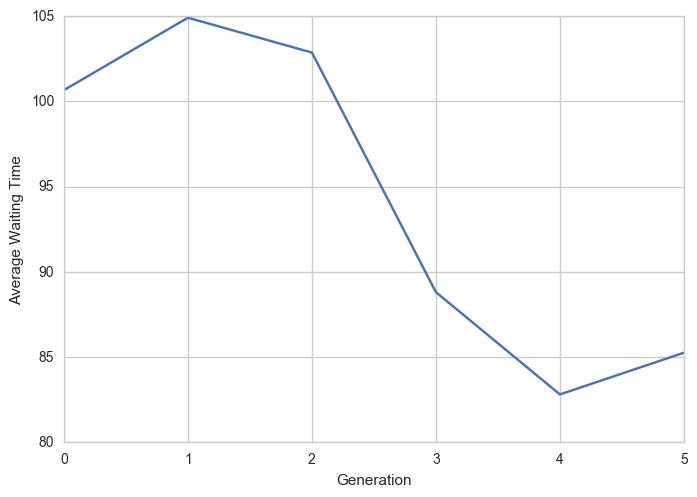

In [19]:
# Plotting

# print the genome distribution before and after the evolution
print(best_perf)
plt.hist(init_genomes[:,0], bins=3, alpha = 0.5, color = 'b')
plt.hist(best_genomes[:,0], bins=3, alpha = 0.5, color = 'g')
plt.show()

# print of Average Waiting Time of the parameters during the evolution process

plt.plot(awt_over_time)
plt.xlabel('Generation')
plt.ylabel('Average Waiting Time')
plt.show()

# DQN Approach

In [23]:
# Initialization of the simulation and model parameters

dqn_simulation = Simulation(DQNMainBus)

replay_memory = deque(maxlen = 100000)

save_every = 10

exploration_parameter = 0.1
decay_rate = 1e-8
epochs = 5
batch_size=100

iterations=144

awt_over_time = []
expenses_over_time = []
messages_over_time = []
delivered_over_time = []
cost_ratio_over_time = []

Initializing Prob Dist


In [25]:
# Main training loop

for epoch in range(epochs):
    print('Epoch #%d' % (epoch+1))
    day_time = 0
    dqn_simulation.reset() # resets everything
    
    while day_time < whole_day:
        dqn_simulation.execute(iterations=iterations) # simulate and collect logs
        
        replay_memory.extend(dqn_simulation.controller.replay_memory) # store data into replay memory

        if len(replay_memory)  > batch_size:
            # Get random samples
            training_idx = np.random.choice(len(replay_memory), size = batch_size)
            training_samples = [replay_memory[i] for i in training_idx]

            # Train DQN
            dqn_simulation.controller.destination_model.train(training_samples)
            
            # Decrease exploration parameter
            DQNMainBus._EXPLORATION_PARAMETER = exploration_parameter
            exploration_parameter -= 1e-8
        
        day_time += iterations
        
    # Display and save results
    awt, expenses, num_messages, num_del, cost_ratio = get_results(dqn_simulation)
    
    awt_over_time.append(awt)
    expenses_over_time.append(expenses)
    messages_over_time.append(num_messages)
    delivered_over_time.append(num_del)
    cost_ratio_over_time.append(cost_ratio)
    
    print('\n\tDelivered: {}'.format(num_del))
    print('\tExpenses: {}'.format(expenses))
    print('\tExpenses/Pass Del: {}'.format(cost_ratio))
    print('\tMessages: {}'.format(num_messages))
    print('\tAWT: {}'.format(awt))
    
    
    if epoch % save_every == 0:
        dqn_simulation.controller.save_destination_model('decision_model_final')
        print('### Saved ###')

Epoch #1
 144 / 144 
	Delivered: 37014
	Expenses: 2590139
	Expenses/Pass Del: 69.97727886745555
	Messages: 12628
	AWT: 154.88895863692412
### Saved ###
Epoch #2
 144 / 144 
	Delivered: 40411
	Expenses: 1493189
	Expenses/Pass Del: 36.95006310163075
	Messages: 12752
	AWT: 136.78403766393902
Epoch #3
 144 / 144 
	Delivered: 38722
	Expenses: 1922519
	Expenses/Pass Del: 49.6492691493208
	Messages: 12672
	AWT: 152.26387176325525
Epoch #4
 144 / 144 
	Delivered: 37275
	Expenses: 2467289
	Expenses/Pass Del: 66.19152246814218
	Messages: 12591
	AWT: 159.03853828046184
Epoch #5
 144 / 144 
	Delivered: 38198
	Expenses: 2183324
	Expenses/Pass Del: 57.15807110319912
	Messages: 12568
	AWT: 152.02167918394798


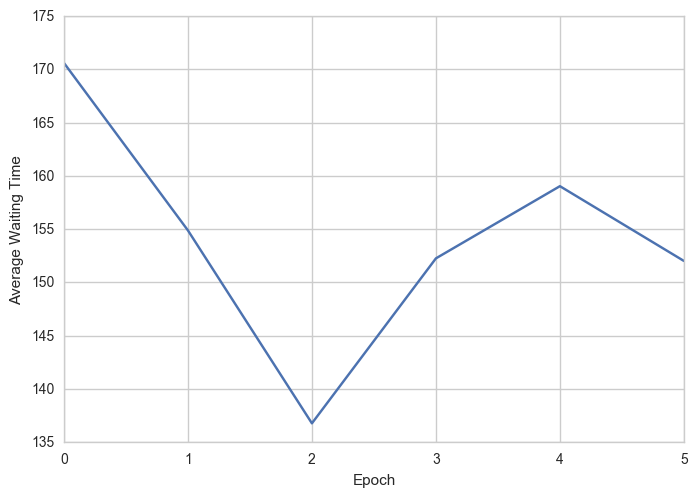

In [26]:
# Plotting
plt.plot(awt_over_time)
plt.xlabel('Epoch')
plt.ylabel('Average Waiting Time')
plt.show()